$$\huge{\textbf{Financial Sentimental Analysis}}$$

# Problem Statement

The main task is to detect the tone of the financial text i.e, positive,negative or neutral using Deep Learning approaches.

# Dataset description

The following data is intended for advancing financial sentiment analysis research. It's two datasets (FiQA, Financial PhraseBank) combined into one easy-to-use CSV file. It provides financial sentences with sentiment labels.

The link to download the dataset: https://www.kaggle.com/datasets/sbhatti/financial-sentiment-analysis

# Methodology

The methodology of the assigment is going to includes the following

1. Data preprocessing:

Data preprocessing includes tokenization, vectorization and train test splitting of data for model training.

2. Models:

the models that are going to be used to train the data are:
 - Basic LSTM
 - Glove + LSTM
 - Glove + GRU
 - FastText + LSTM

## Data preprocessing

In [1]:
!pip install text_hammer
import cv2
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import cm
import text_hammer as th
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook as tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 916.0 kB/s eta 0:00:00a 0:00:01
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.11.1
    Uninstalling beautifulsoup4-4.11.1:
      Successfully uninstalled beautifulsoup4-4.11.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.


In [2]:
df = pd.read_csv('../input/financial-sentiment-analysis/data.csv')

In [3]:
df.head(10)

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
5,$SPY wouldn't be surprised to see a green close,positive
6,Shell's $70 Billion BG Deal Meets Shareholder ...,negative
7,SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...,negative
8,Kone 's net sales rose by some 14 % year-on-ye...,positive
9,The Stockmann department store will have a tot...,neutral


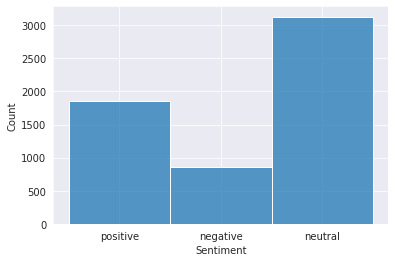

In [4]:
import seaborn as sns
sns.set_style('darkgrid')
sns.histplot(x='Sentiment',data=df)
plt.show()

In [5]:
df['len'] = list(map(lambda x: len(str(x).split(' ')),df['Sentence']))
df.head()

,Sentence,Sentiment,len
0,The GeoSolutions technology will leverage Bene...,positive,32
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,11
2,"For the last quarter of 2010 , Componenta 's n...",positive,39
3,According to the Finnish-Russian Chamber of Co...,neutral,20
4,The Swedish buyout firm has sold its remaining...,neutral,23


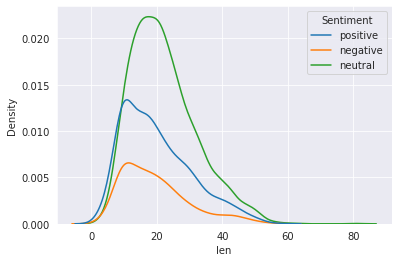

In [6]:
sns.kdeplot(x='len',hue='Sentiment',data=df)
plt.show()

In [7]:
mapdf = {'positive':0,'negative':1,'neutral':2}
df['Sentiment'] = list(map(lambda x:mapdf[x],df['Sentiment']))
df.head()

,Sentence,Sentiment,len
0,The GeoSolutions technology will leverage Bene...,0,32
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",1,11
2,"For the last quarter of 2010 , Componenta 's n...",0,39
3,According to the Finnish-Russian Chamber of Co...,2,20
4,The Swedish buyout firm has sold its remaining...,2,23


In [8]:
print(df['Sentiment'].corr(df['len']))

0.10137114484667775


In [9]:
sentences = df['Sentence'].copy()[:]
sentences = sentences.to_list()
sentences = list(map(lambda x: x.lower(),sentences))
sentences = list(map(lambda x: th.cont_exp(x),sentences))
sentences = list(map(lambda x: th.remove_emails(x),sentences))
sentences = list(map(lambda x: th.remove_emails(x),sentences))
sentences = list(map(lambda x: th.remove_html_tags(x),sentences))
sentences = list(map(lambda x: th.remove_stopwords(x),sentences))
sentences = list(map(lambda x: th.remove_special_chars(x),sentences))
sentences = list(map(lambda x: th.remove_accented_chars(x),sentences))
sentences = list(map(lambda x: th.make_base(x),sentences))

In [10]:
sentences[:3]

['geosolution technology leverage benefon global positioning system solution provide location base search technology community platform location relevant multimedia content new powerful commercial model',
 'esi lows 150 250 bk real possibility',
 'quarter 2010 componenta net sale double eur131 m eur76 m period year early move zero pretax profit pretax loss eur7 m']

In [11]:
import nltk
pairs = []
for sent in tqdm(sentences):
    pairs.extend(nltk.word_tokenize(sent))
freq = nltk.FreqDist(pairs)
freq.most_common(10)

  0%|          | 0/5842 [00:00<?, ?it/s]

[('eur', 1284),
 ('company', 915),
 ('mn', 729),
 ('sale', 595),
 ('profit', 584),
 ('say', 574),
 ('finnish', 527),
 ('share', 512),
 ('net', 499),
 ('million', 493)]

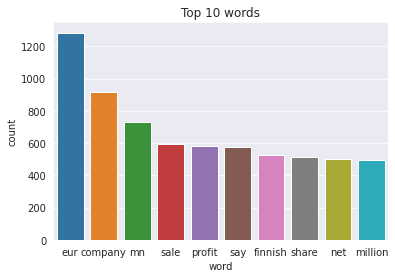

In [12]:
tempdf = pd.DataFrame(freq.most_common(10),  columns=['word', 'count'])
sns.barplot(x='word',y='count',data=tempdf)
plt.title("Top 10 words")
plt.show()

In [13]:
from sklearn.model_selection import train_test_split
from keras.utils.all_utils import to_categorical
y = to_categorical(df['Sentiment'])
x = sentences.copy()
X_train,X_test, y_train,y_test = train_test_split(x,y,test_size=0.3,stratify=y,random_state=42)

## Vectorization

In [14]:
from keras.preprocessing.text import Tokenizer
num_words = 12000 
tokenizer=Tokenizer(num_words,lower=True)
df_total = pd.concat([pd.Series(X_train), pd.Series(X_test)], axis = 0)
tokenizer.fit_on_texts(df_total)

In [15]:
from keras.preprocessing.sequence import pad_sequences

X_train_ =tokenizer.texts_to_sequences(X_train)
X_train_pad=pad_sequences(X_train_,maxlen=81,padding='post')
X_test_ = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_, maxlen = 81, padding = 'post')

In [16]:
print(X_train_pad.shape,X_test_pad.shape)

(4089, 81) (1753, 81)


## LSTM

In [17]:
from keras.models import Sequential
from keras.layers import LSTM,Dense,Bidirectional,Embedding,Dropout

In [18]:
lstm = Sequential()
lstm.add(Embedding(input_dim = num_words,
                          output_dim = 100,
                          input_length= X_train_pad.shape[1]))
lstm.add(Dropout(0.2))
lstm.add(Bidirectional(LSTM(128,return_sequences=True)))
lstm.add(Dropout(0.2))
lstm.add(Bidirectional(LSTM(256,return_sequences=True)))
lstm.add(Dropout(0.2))
lstm.add(Bidirectional(LSTM(128,return_sequences=False)))
lstm.add(Dense(64,activation='tanh'))
lstm.add(Dense(32,activation='tanh'))
lstm.add(Dense(10,activation='tanh'))
lstm.add(Dense(3,activation='softmax'))

2022-12-20 06:15:29.073812: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 06:15:29.075079: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 06:15:29.075776: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 06:15:29.076596: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [19]:
lstm.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [20]:
lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 81, 100)           1200000   
_________________________________________________________________
dropout (Dropout)            (None, 81, 100)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 81, 256)           234496    
_________________________________________________________________
dropout_1 (Dropout)          (None, 81, 256)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 81, 512)           1050624   
_________________________________________________________________
dropout_2 (Dropout)          (None, 81, 512)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               6

In [21]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('./model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [22]:
lstm_history = lstm.fit(X_train_pad,y_train, epochs = 10, batch_size = 64, validation_data=(X_test_pad, y_test),verbose = 1, callbacks= [es, mc])

Epoch 1/10


2022-12-20 06:15:38.303971: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-20 06:15:45.567229: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


64/64 [==============================] - 14s 89ms/step - loss: 0.9319 - accuracy: 0.5693 - val_loss: 0.8378 - val_accuracy: 0.6532

Epoch 00001: val_accuracy improved from -inf to 0.65317, saving model to ./model.h5
Epoch 2/10
64/64 [==============================] - 3s 52ms/step - loss: 0.6596 - accuracy: 0.7422 - val_loss: 0.8265 - val_accuracy: 0.6509

Epoch 00002: val_accuracy did not improve from 0.65317
Epoch 3/10
64/64 [==============================] - 3s 53ms/step - loss: 0.4551 - accuracy: 0.8198 - val_loss: 0.8583 - val_accuracy: 0.6737

Epoch 00003: val_accuracy improved from 0.65317 to 0.67370, saving model to ./model.h5
Epoch 4/10
64/64 [==============================] - 3s 52ms/step - loss: 0.2873 - accuracy: 0.8799 - val_loss: 0.9929 - val_accuracy: 0.6338

Epoch 00004: val_accuracy did not improve from 0.67370
Epoch 5/10
64/64 [==============================] - 3s 53ms/step - loss: 0.2471 - accuracy: 0.8868 - val_loss: 1.0029 - val_accuracy: 0.6321

Epoch 00005: val_ac

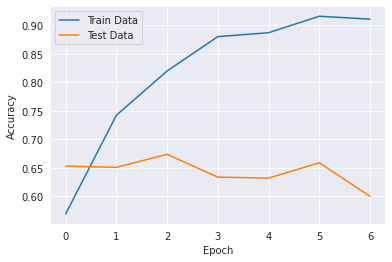

In [23]:
plt.plot(lstm_history.history['accuracy'], label='Train Data')
plt.plot(lstm_history.history['val_accuracy'], label='Test Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.8, 1])
plt.legend(loc='best')
plt.show()

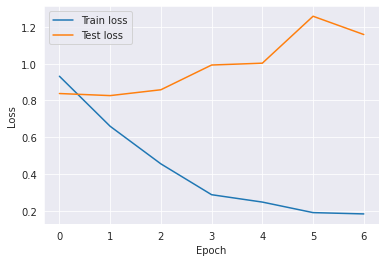

In [24]:
plt.plot(lstm_history.history['loss'], label='Train loss')
plt.plot(lstm_history.history['val_loss'], label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

In [25]:
from sklearn.metrics import classification_report
predictions = lstm.predict(X_test_pad)
target_names=['positive','negative','neutral']
print(classification_report(np.argmax(y_test,axis=1),np.argmax(predictions,axis=1),target_names=target_names))

              precision    recall  f1-score   support

    positive       0.71      0.57      0.63       556
    negative       0.25      0.40      0.31       258
     neutral       0.70      0.67      0.69       939

    accuracy                           0.60      1753
   macro avg       0.55      0.55      0.54      1753
weighted avg       0.64      0.60      0.61      1753



## Glove+LSTM

In [26]:
import gensim.downloader as api
glove_gensim  = api.load('glove-wiki-gigaword-300')

[==================================================] 100.0% 376.1/376.1MB downloaded


In [27]:
glove_gensim.most_similar(positive=['king','woman'],negative=['man'],topn=1)

[('queen', 0.6713277101516724)]

In [28]:
vector_size = 300
gensim_weight_matrix = np.zeros((num_words ,vector_size))
gensim_weight_matrix.shape

for word, index in tqdm(tokenizer.word_index.items()):
    if index < num_words: # since index starts with zero 
        try:
            gensim_weight_matrix[index] = glove_gensim[word]
        except:
            gensim_weight_matrix[index] = np.zeros(300)

  0%|          | 0/10891 [00:00<?, ?it/s]

In [29]:
gensim_weight_matrix.shape

(12000, 300)

In [30]:
glove = Sequential()
glove.add(Embedding(input_dim = num_words,
                          output_dim = 300,
                          input_length= X_train_pad.shape[1],
                          weights = [gensim_weight_matrix],
                          trainable = False))
glove.add(Dropout(0.2))
glove.add(Bidirectional(LSTM(128,return_sequences=True)))
glove.add(Dropout(0.2))
glove.add(Bidirectional(LSTM(256,return_sequences=True)))
glove.add(Dropout(0.2))
glove.add(Bidirectional(LSTM(128,return_sequences=False)))
glove.add(Dense(64,activation='tanh'))
glove.add(Dense(32,activation='tanh'))
glove.add(Dense(10,activation='tanh'))
glove.add(Dense(3,activation='softmax'))

In [31]:
glove.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 81, 300)           3600000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 81, 300)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 81, 256)           439296    
_________________________________________________________________
dropout_4 (Dropout)          (None, 81, 256)           0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 81, 512)           1050624   
_________________________________________________________________
dropout_5 (Dropout)          (None, 81, 512)           0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 256)              

In [32]:
glove.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [33]:
glove_history = glove.fit(X_train_pad,y_train, epochs = 10, batch_size = 64, validation_data=(X_test_pad, y_test),verbose = 1, callbacks= [es, mc])

Epoch 1/10
64/64 [==============================] - 12s 79ms/step - loss: 0.8700 - accuracy: 0.6070 - val_loss: 0.8007 - val_accuracy: 0.6583

Epoch 00001: val_accuracy did not improve from 0.67370
Epoch 2/10
64/64 [==============================] - 3s 54ms/step - loss: 0.7309 - accuracy: 0.6850 - val_loss: 0.7571 - val_accuracy: 0.6845

Epoch 00002: val_accuracy improved from 0.67370 to 0.68454, saving model to ./model.h5
Epoch 3/10
64/64 [==============================] - 3s 54ms/step - loss: 0.6747 - accuracy: 0.7085 - val_loss: 0.7320 - val_accuracy: 0.7005

Epoch 00003: val_accuracy improved from 0.68454 to 0.70051, saving model to ./model.h5
Epoch 4/10
64/64 [==============================] - 3s 54ms/step - loss: 0.6136 - accuracy: 0.7400 - val_loss: 0.7190 - val_accuracy: 0.6971

Epoch 00004: val_accuracy did not improve from 0.70051
Epoch 5/10
64/64 [==============================] - 3s 54ms/step - loss: 0.5622 - accuracy: 0.7650 - val_loss: 0.6930 - val_accuracy: 0.7148

Epoch

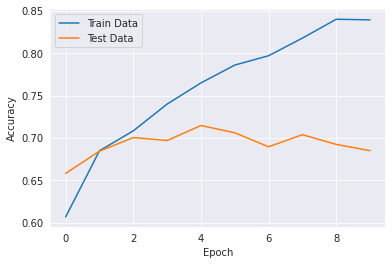

In [34]:
plt.plot(glove_history.history['accuracy'], label='Train Data')
plt.plot(glove_history.history['val_accuracy'], label='Test Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.98, 1])
plt.legend(loc='best')
plt.show()

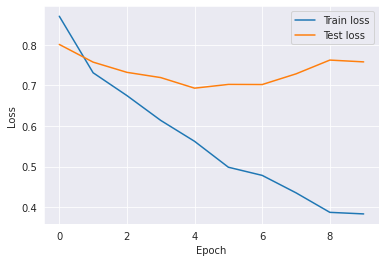

In [35]:
plt.plot(glove_history.history['loss'], label='Train loss')
plt.plot(glove_history.history['val_loss'], label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

In [36]:
predictions = glove.predict(X_test_pad)
target_names=['positive','negative','neutral']
print(classification_report(np.argmax(y_test,axis=1),np.argmax(predictions,axis=1),target_names=target_names))

              precision    recall  f1-score   support

    positive       0.65      0.79      0.72       556
    negative       0.43      0.50      0.46       258
     neutral       0.81      0.67      0.74       939

    accuracy                           0.69      1753
   macro avg       0.63      0.66      0.64      1753
weighted avg       0.70      0.69      0.69      1753



## Glove+GRU

In [37]:
from keras.layers import GRU
gru = Sequential()
gru.add(Embedding(input_dim = num_words,
                          output_dim = 300,
                          input_length= X_train_pad.shape[1],
                          weights = [gensim_weight_matrix],
                          trainable = False))
gru.add(Dropout(0.2))
gru.add(Bidirectional(GRU(128,return_sequences=True)))
gru.add(Dropout(0.2))
gru.add(Bidirectional(GRU(256,return_sequences=True)))
gru.add(Dropout(0.2))
gru.add(Bidirectional(GRU(128,return_sequences=False)))
gru.add(Dense(64,activation='tanh'))
gru.add(Dense(32,activation='tanh'))
gru.add(Dense(10,activation='tanh'))
gru.add(Dense(3,activation='softmax'))

In [38]:
gru.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 81, 300)           3600000   
_________________________________________________________________
dropout_6 (Dropout)          (None, 81, 300)           0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 81, 256)           330240    
_________________________________________________________________
dropout_7 (Dropout)          (None, 81, 256)           0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 81, 512)           789504    
_________________________________________________________________
dropout_8 (Dropout)          (None, 81, 512)           0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 256)              

In [39]:
gru.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [40]:
gru_history = gru.fit(X_train_pad,y_train, epochs = 10, batch_size = 64, validation_data=(X_test_pad, y_test),verbose = 1, callbacks= [es, mc])

Epoch 1/10
64/64 [==============================] - 11s 73ms/step - loss: 0.8644 - accuracy: 0.6033 - val_loss: 0.8145 - val_accuracy: 0.6389

Epoch 00001: val_accuracy did not improve from 0.71477
Epoch 2/10
64/64 [==============================] - 3s 48ms/step - loss: 0.7229 - accuracy: 0.6816 - val_loss: 0.7416 - val_accuracy: 0.6851

Epoch 00002: val_accuracy did not improve from 0.71477
Epoch 3/10
64/64 [==============================] - 3s 48ms/step - loss: 0.6729 - accuracy: 0.7073 - val_loss: 0.7121 - val_accuracy: 0.6948

Epoch 00003: val_accuracy did not improve from 0.71477
Epoch 4/10
64/64 [==============================] - 3s 48ms/step - loss: 0.6133 - accuracy: 0.7413 - val_loss: 0.6954 - val_accuracy: 0.7017

Epoch 00004: val_accuracy did not improve from 0.71477
Epoch 5/10
64/64 [==============================] - 3s 48ms/step - loss: 0.5598 - accuracy: 0.7628 - val_loss: 0.7293 - val_accuracy: 0.6988

Epoch 00005: val_accuracy did not improve from 0.71477
Epoch 6/10
64/

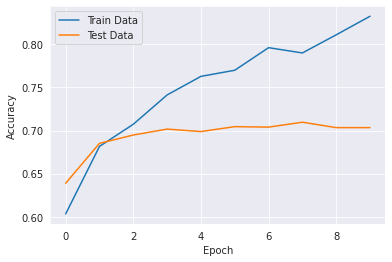

In [41]:
plt.plot(gru_history.history['accuracy'], label='Train Data')
plt.plot(gru_history.history['val_accuracy'], label='Test Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.7, 1])
plt.legend(loc='best')
plt.show()

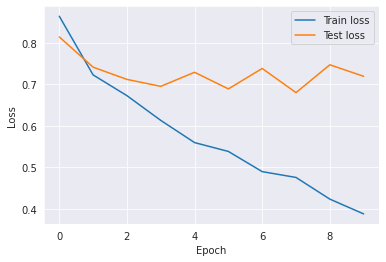

In [42]:
plt.plot(gru_history.history['loss'], label='Train loss')
plt.plot(gru_history.history['val_loss'], label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

In [43]:
predictions = gru.predict(X_test_pad)
target_names=['positive','negative','neutral']
print(classification_report(np.argmax(y_test,axis=1),np.argmax(predictions,axis=1),target_names=target_names))

              precision    recall  f1-score   support

    positive       0.77      0.67      0.71       556
    negative       0.40      0.37      0.39       258
     neutral       0.74      0.82      0.78       939

    accuracy                           0.70      1753
   macro avg       0.64      0.62      0.63      1753
weighted avg       0.70      0.70      0.70      1753



## Fasttext+LSTM

In [ ]:
import gensim.downloader as api
glove_gensim  = api.load('fasttext-wiki-news-subwords-300')

[=======-------------------------------------------] 15.8% 151.3/958.4MB downloaded

In [ ]:
vector_size = 300
gensim_weight_matrix = np.zeros((num_words ,vector_size))
gensim_weight_matrix.shape

for word, index in tqdm(tokenizer.word_index.items()):
    if index < num_words: # since index starts with zero 
        try:
            gensim_weight_matrix[index] = glove_gensim[word]
        except:
            gensim_weight_matrix[index] = np.zeros(300)

In [ ]:
ftext = Sequential()
ftext.add(Embedding(input_dim = num_words,
                          output_dim = 300,
                          input_length= X_train_pad.shape[1],
                          weights = [gensim_weight_matrix],
                          trainable = False))
ftext.add(Dropout(0.2))
ftext.add(Bidirectional(LSTM(128,return_sequences=True)))
ftext.add(Dropout(0.2))
ftext.add(Bidirectional(LSTM(256,return_sequences=True)))
ftext.add(Dropout(0.2))
ftext.add(Bidirectional(LSTM(128,return_sequences=False)))
ftext.add(Dense(64,activation='tanh'))
ftext.add(Dense(32,activation='tanh'))
ftext.add(Dense(10,activation='tanh'))
ftext.add(Dense(3,activation='softmax'))

In [ ]:
ftext.summary()

In [ ]:
ftext.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
ftext_history = ftext.fit(X_train_pad,y_train, epochs = 10, batch_size = 64, validation_data=(X_test_pad, y_test),verbose = 1, callbacks= [es, mc])

In [ ]:
plt.plot(ftext_history.history['accuracy'], label='Train Data')
plt.plot(ftext_history.history['val_accuracy'], label='Test Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.8, 1])
plt.legend(loc='best')
plt.show()

In [ ]:
plt.plot(ftext_history.history['loss'], label='Train loss')
plt.plot(ftext_history.history['val_loss'], label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

In [ ]:
predictions = ftext.predict(X_test_pad)
target_names=['positive','negative','neutral']
print(classification_report(np.argmax(y_test,axis=1),np.argmax(predictions,axis=1),target_names=target_names))

## Results

|S.No|Vector Embedding|Reccurent layer|Accuracy|
|--|--|--|--|
|1|None|LSTM|65%|
|2|Glove|LSTM|70%|
|3|Glove|GRU|72%|
|4|FastText|LSTM|68%|

# Conclusion

The main goal of the work is to produce a model that is capable of identifying the tone of financial news.This is acheived using RNN models such as LSTM and GRU using various embeddings .It is to be noted that the dataset is not capable enough to identify tone perfectly as classes are imbalanced and best accuracy is produced by GLove+GRU model which is 72%.

The real life application of this work can be useful in various approaches such as automation of financial analysis, extracting profits and loses easily and many more.This work is a beginner step in building more complicated approaches.